In [30]:
#NBVAL_IGNORE_OUTPUT
# Adding ignore due to (probably an np notebook magic) bug
import numpy as np
%matplotlib inline

In [31]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, plot_velocity

# Define a physical size
shape = (151, 101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10., 10)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :, :51] = 1.5
v[:, :, 51:] = 2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=8, nbl=50, bcs="damp")

# plot_velocity(model)

Operator `initdamp` ran in 0.02 s


In [32]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
# Time step from model grid spacing
print('CFL',model.critical_dt)
dt = 1.0 # ms dt < model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)

CFL 1.695


Operator `initdamp` ran in 0.01 s


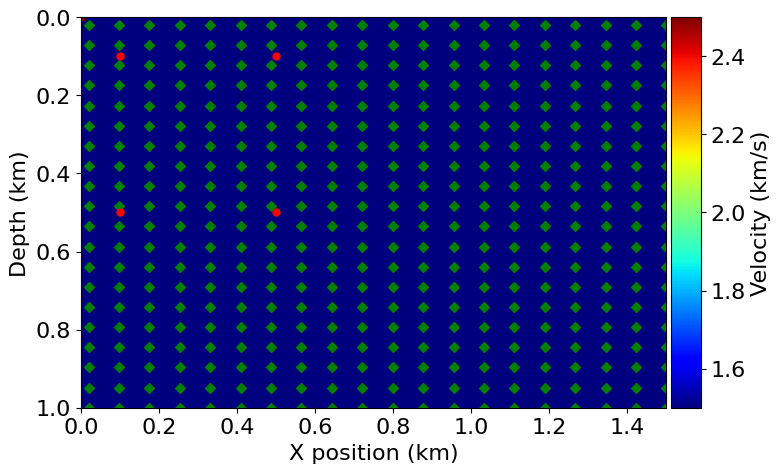

In [33]:
from examples.seismic import Receiver
from examples.seismic import RickerSource

# plot the positions of sources and receivers on a 2D plane

# Define a physical size
shape_2d = (151, 101)  # Number of grid point (nx, nz)
spacing_2d = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin_2d = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v_2d = np.empty(shape_2d, dtype=np.float32)
v_2d[:, :] = 1.5
v_2d[0, 0] = 2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model_2d = Model(vp=v_2d, origin=origin_2d, shape=shape_2d, spacing=spacing_2d,
              space_order=8, nbl=50, bcs="damp")

f0 = 0.015  # Source peak frequency is 15Hz (0.015 kHz)

src_2d = RickerSource(name='src', grid=model_2d.grid, f0=f0,
                   npoint=4, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
# src_2d.coordinates.data[:,0] = np.repeat(np.linspace(100, model_2d.domain_size[0], num=2), 2)
# src_2d.coordinates.data[:,1] = np.tile(np.linspace(100, model_2d.domain_size[1], num=2), 2)
src_2d.coordinates.data[:,0] = np.repeat(np.linspace(100, 500, num=2), 2)
src_2d.coordinates.data[:,1] = np.tile(np.linspace(100, 500, num=2), 2)

# Create symbol for 101 receivers
rec_2d = Receiver(name='rec', grid=model_2d.grid, npoint=400, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec_2d.coordinates.data[:, 0] = np.repeat(np.linspace(20, model_2d.domain_size[0], num=20), 20)
rec_2d.coordinates.data[:, 1] = np.tile(np.linspace(20, model_2d.domain_size[1], num=20), 20)

plot_velocity(model_2d, source=src_2d.coordinates.data,
              receiver=rec_2d.coordinates.data[:,:])

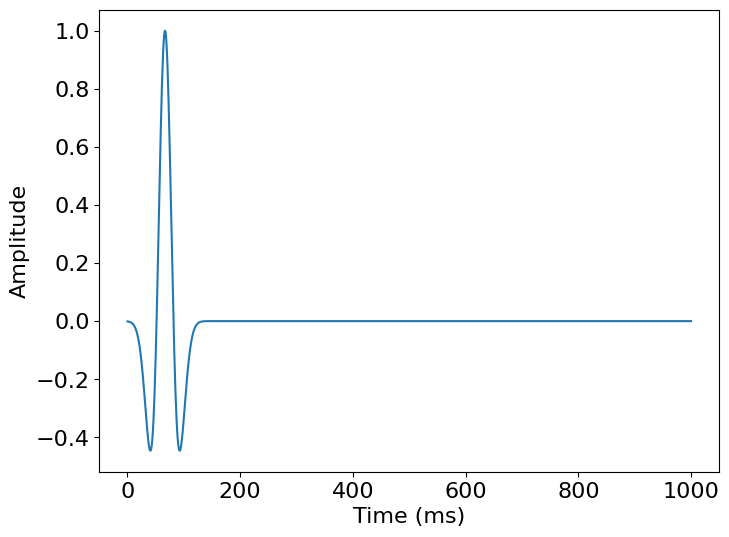

In [34]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

def check_points_per_wavelength(min_vel, freq, dx, dt):
    if freq is not None:
        
        min_vel = min_vel*1000
        freq = freq*1000
        dt = dt/1000
        min_wavelength = min_vel / freq
        max_spacing = dx
        if min_wavelength / max_spacing <= 6:
            print("At least six grid cells per wavelength is "
                          "recommended, but at a frequency of {}, a "
                          "minimum velocity of {}, and a grid cell "
                          "spacing of {}, there are only {}."
                          .format(freq, min_vel, max_spacing,
                                  min_wavelength / max_spacing))
        if 1/2/dt < freq:
            print("The provided freq is greater than the "
                          "Nyquist frequency of the data.")

f0 = 0.015  # Source peak frequency is 10Hz (0.010 kHz)
check_points_per_wavelength(np.min(v), f0, np.max(spacing), dt)

src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
# src_2d.coordinates.data[:,0] = np.repeat(np.linspace(100, model_2d.domain_size[0], num=2), 2)
# src_2d.coordinates.data[:,1] = np.tile(np.linspace(100, model_2d.domain_size[1], num=2), 2)
src.coordinates.data[:,0] = 400
src.coordinates.data[:,1] = 400
src.coordinates.data[0,2] = 20.  # Depth is 20m

# We can plot the time signature to see the wavelet
src.show()

In [35]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=400, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.repeat(np.linspace(20, model.domain_size[0], num=20), 20)
rec.coordinates.data[:, 1] = np.tile(np.linspace(20, model.domain_size[1], num=20), 20)
rec.coordinates.data[:, 2] = 20.  # Depth is 20m

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
# plot_velocity(model, source=src.coordinates.data,
#               receiver=rec.coordinates.data[::4, :])

In [56]:
# In order to represent the wavefield u and the square slowness we need symbolic objects 
# corresponding to time-space-varying field (u, TimeFunction) and 
# space-varying field (m, Function)
from devito import TimeFunction

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=8)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# The PDE representation is as on paper
pde

damp(x, y, z)*Derivative(u(t, x, y, z), t) - Derivative(u(t, x, y, z), (x, 2)) - Derivative(u(t, x, y, z), (y, 2)) - Derivative(u(t, x, y, z), (z, 2)) + Derivative(u(t, x, y, z), (t, 2))/vp(x, y, z)**2

In [57]:
# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions
from devito import Eq, solve

stencil = Eq(u.forward, solve(pde, u.forward))
stencil

Eq(u(t + dt, x, y, z), (-(-2.0*u(t, x, y, z)/dt**2 + u(t - dt, x, y, z)/dt**2)/vp(x, y, z)**2 + Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2)) + damp(x, y, z)*u(t, x, y, z)/dt)/(damp(x, y, z)/dt + 1/(dt**2*vp(x, y, z)**2)))

In [58]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

In [59]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

# op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map, platform='nvidiaX', opt=('advanced', {'gpu-fit': u}))
op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

In [60]:
#NBVAL_IGNORE_OUTPUT
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 24.89 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=24.835448000000024, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.000522000000000006, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.045768000000000135, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [61]:
rec.data.shape

(1001, 400)

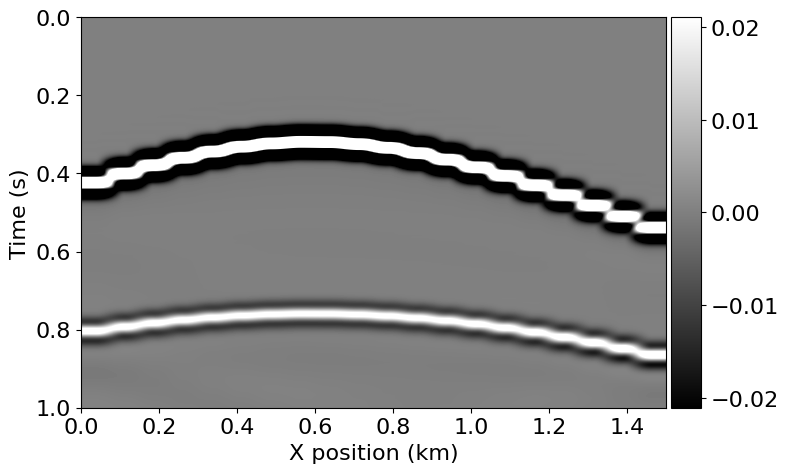

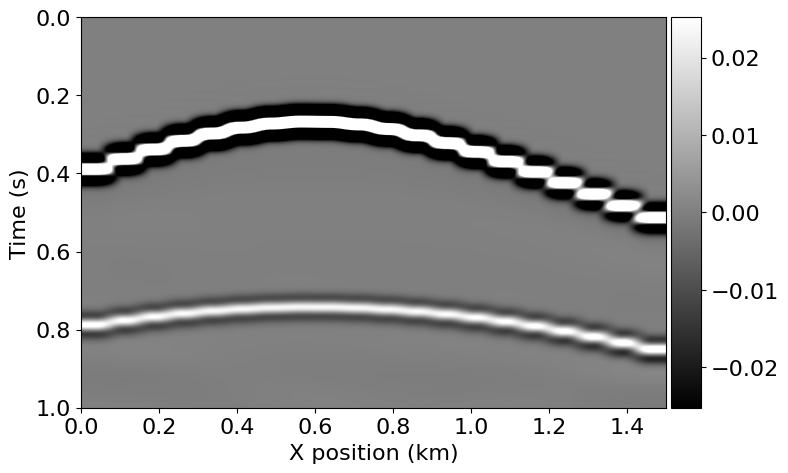

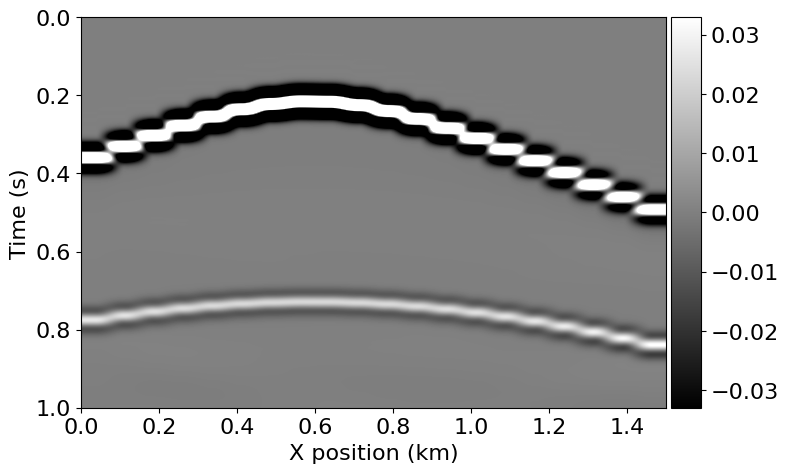

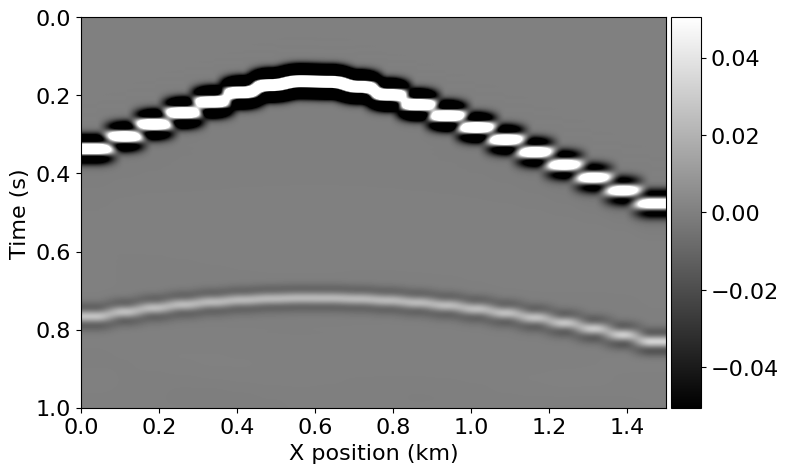

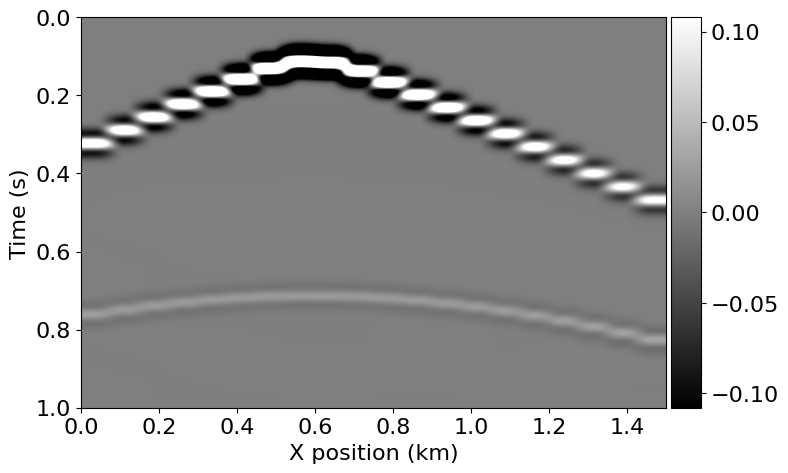

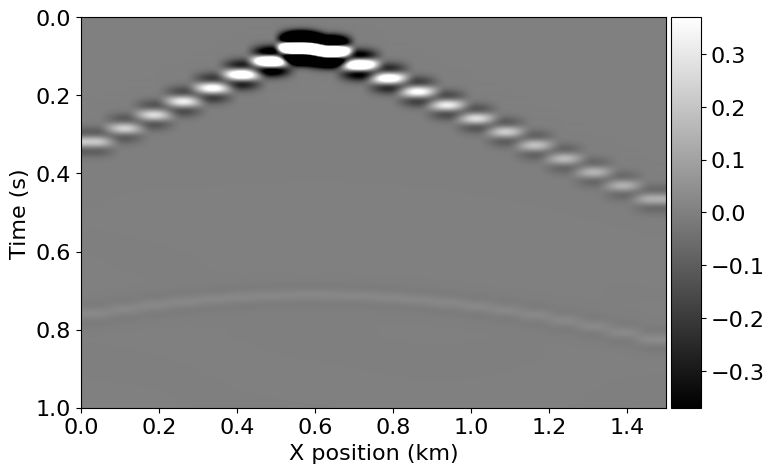

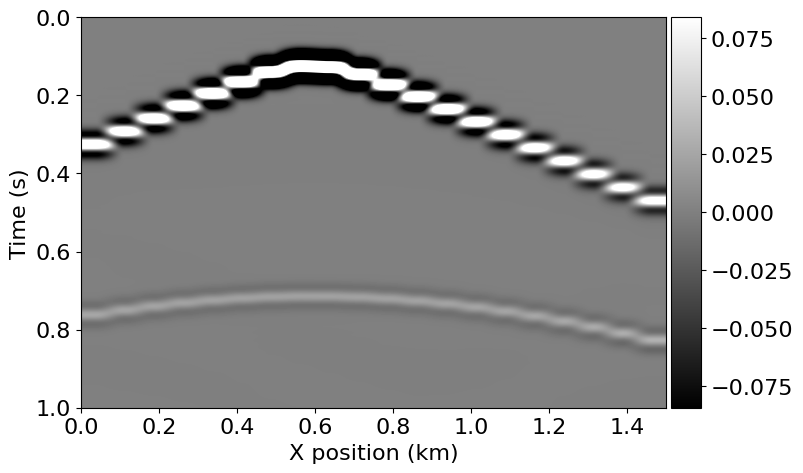

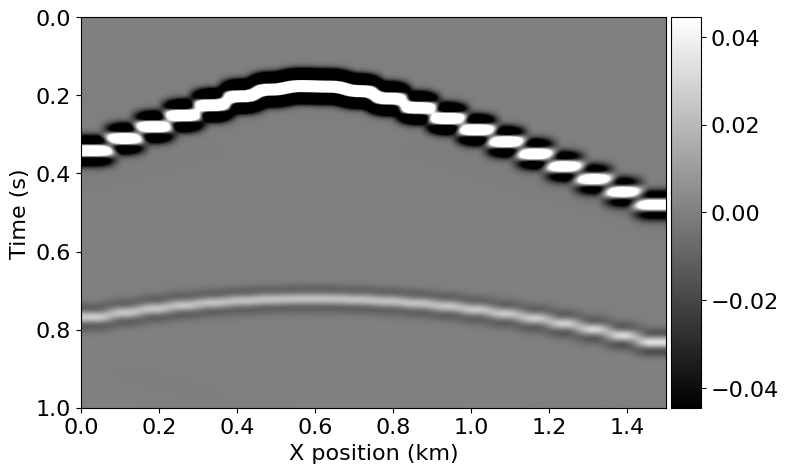

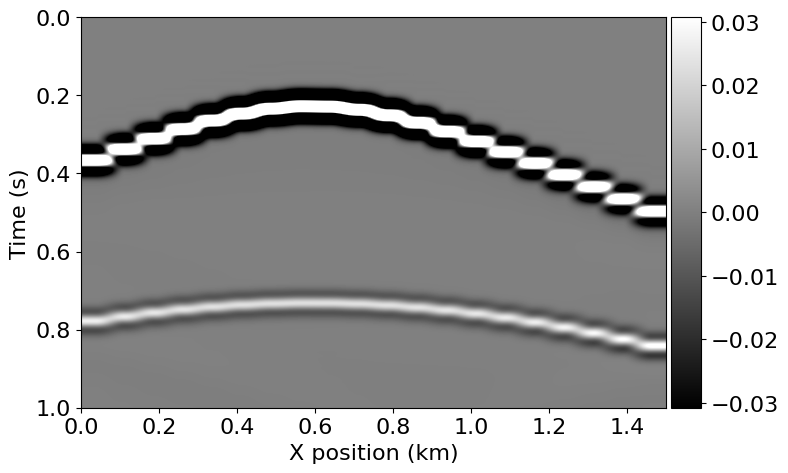

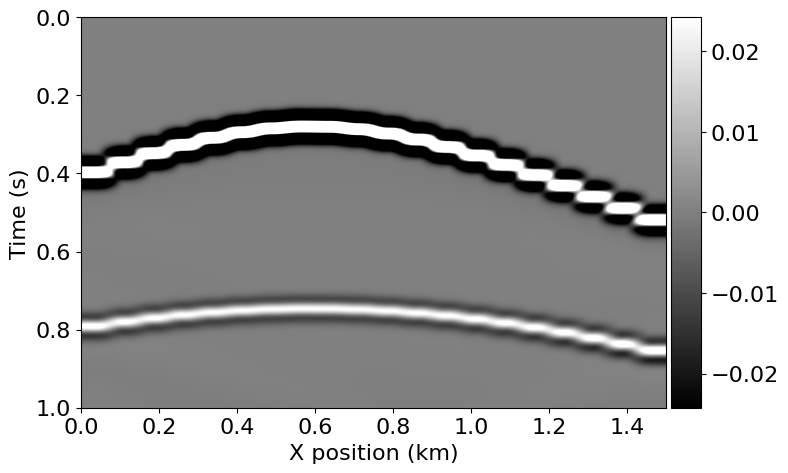

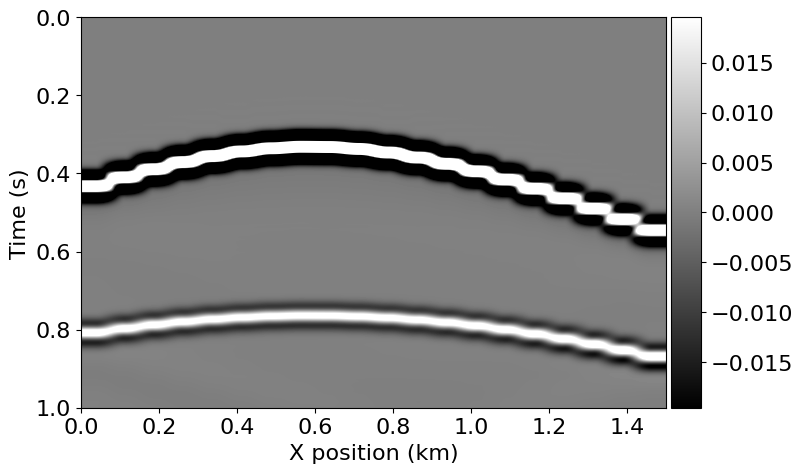

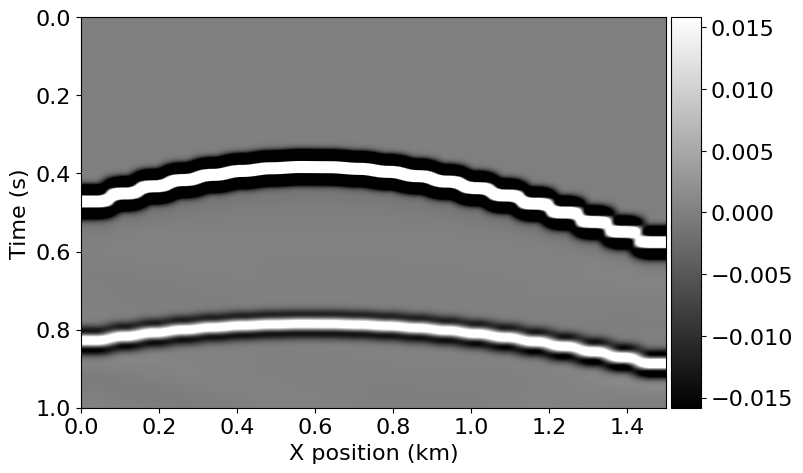

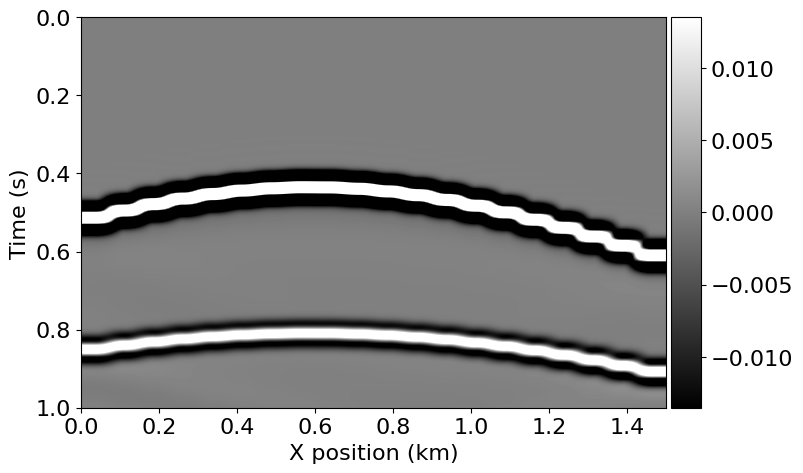

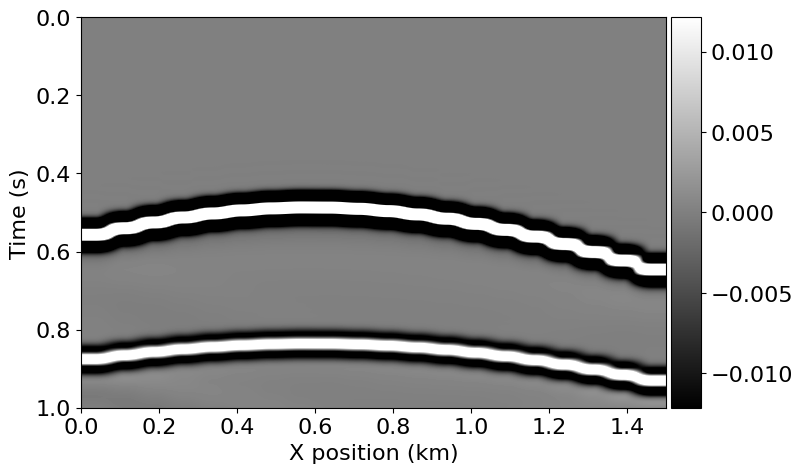

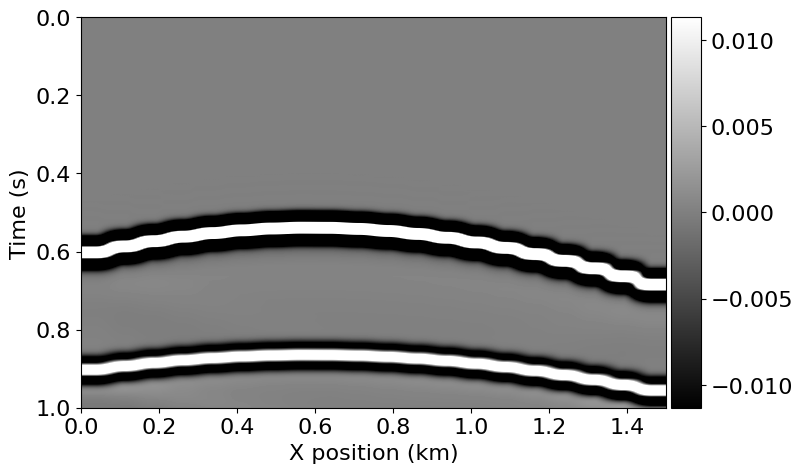

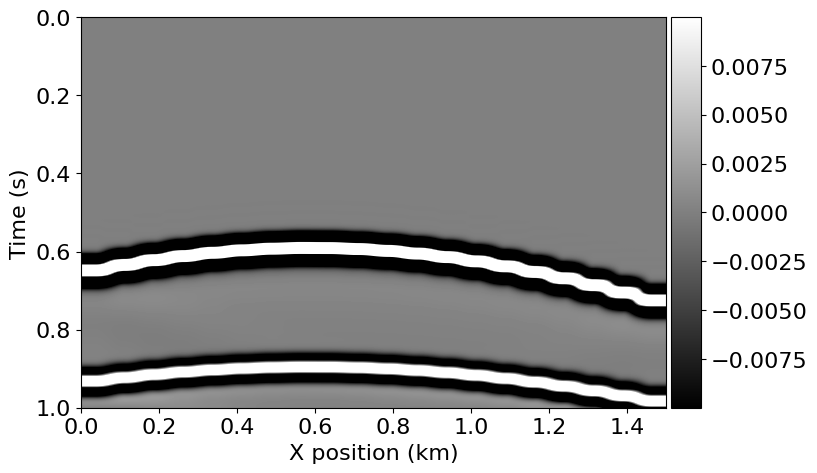

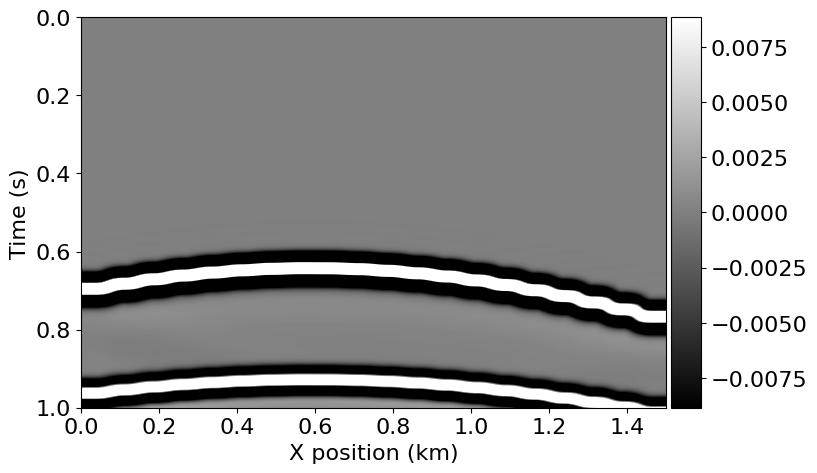

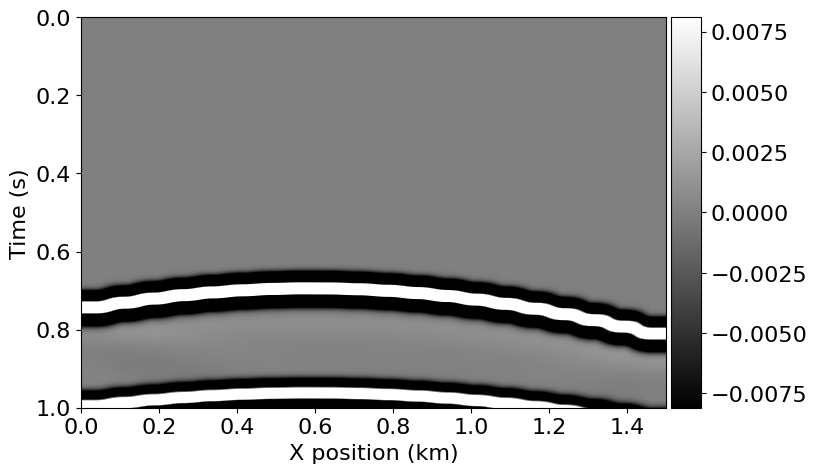

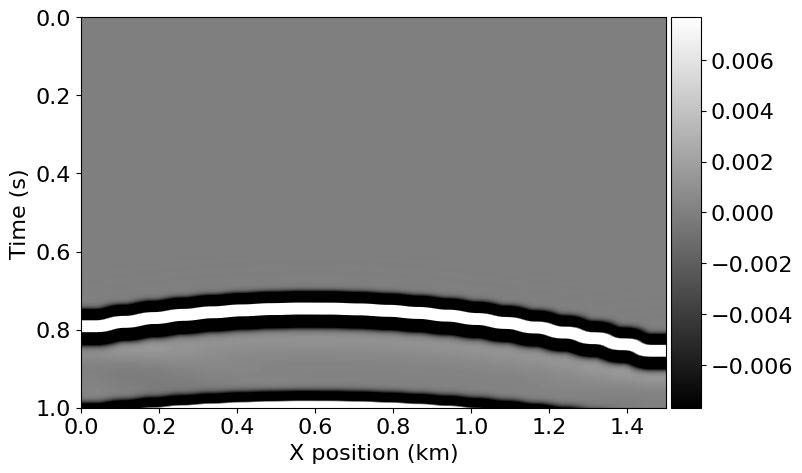

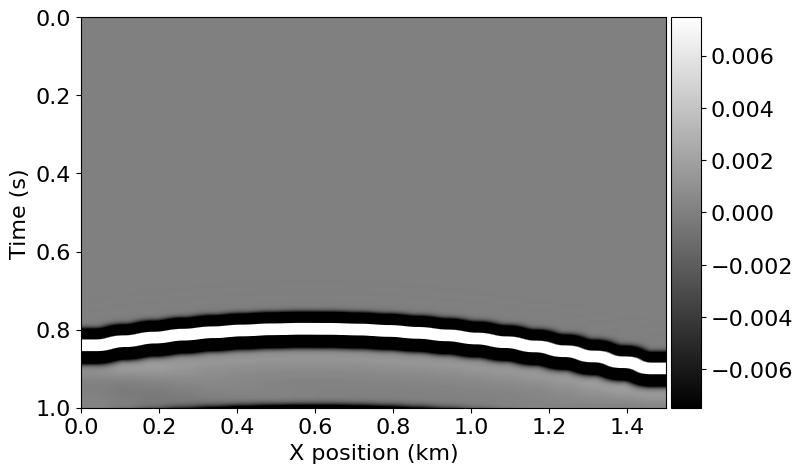

In [62]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

# t x y
temp = rec.data.reshape(1001,20,20)

for index in range(20):
    plot_shotrecord(temp[:,index,:], model, t0, tn)
    

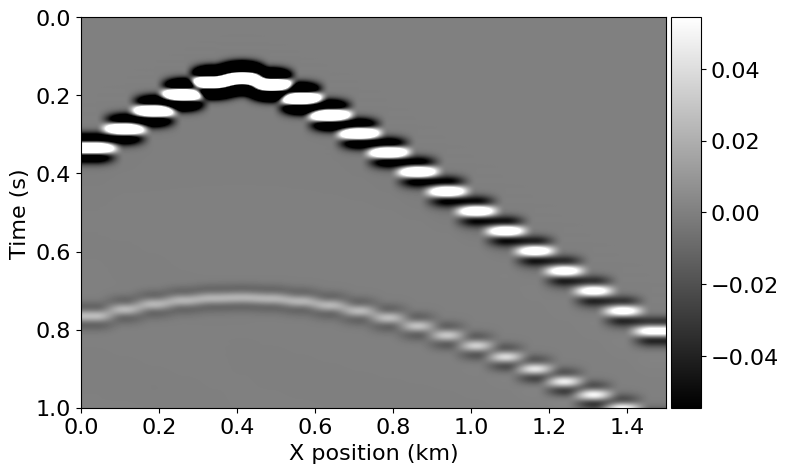

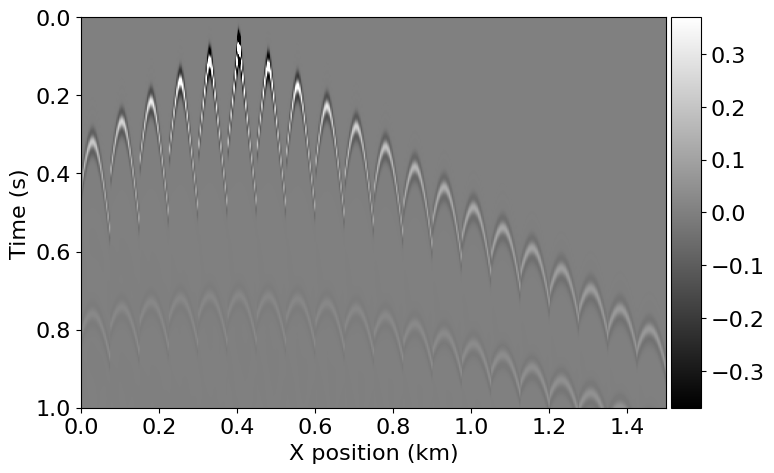

In [63]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

# t x y
temp = rec.data.reshape(1001,20,20)
plot_shotrecord(temp[:,:,10], model, t0, tn)

plot_shotrecord(rec.data, model, t0, tn)

In [25]:
import scipy.io as spio

file_save_data = './data/'
spio.savemat(file_save_data + 'data.mat',{'rec_data':rec.data,})


In [26]:
rec.data.shape

(1001, 400)

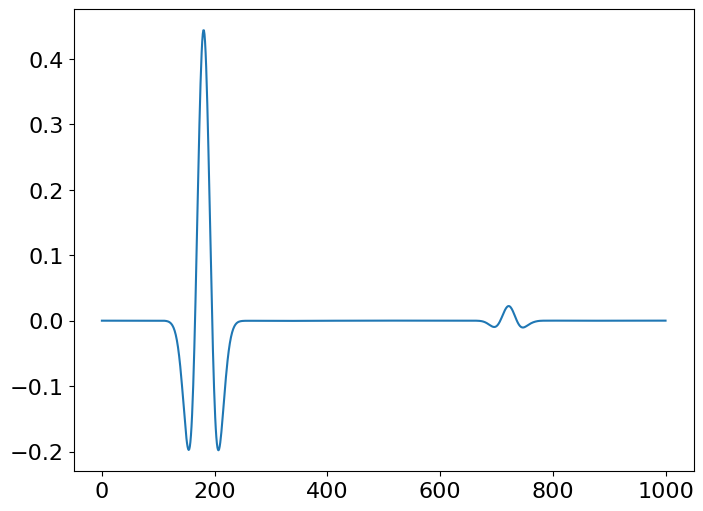

In [27]:
import matplotlib.pyplot as plt

plt.plot(rec.data[:,90])
